In [ ]:
pip install ucimlrepo

In [ ]:
import pandas as pd
import pylab as pl
import numpy as np
import seaborn as sns
import scipy.optimize as opt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, \
f1_score, classification_report,ConfusionMatrixDisplay
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import datasets
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [ ]:
digits = datasets.load_digits()

In [ ]:
print(digits.keys())

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


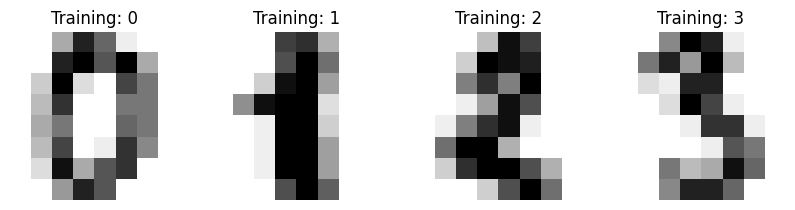

In [ ]:
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Training: %i" % label)

In [ ]:
X = digits.data
y = digits.target

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=365, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X,y, test_size = 0.5, random_state=365, stratify=y)

In [ ]:
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)
y_val = np.asarray(y_val)

In [ ]:
x_train = np.asarray(X_train)
x_test = np.asarray(X_test)
X_val = np.asarray(X_val)

In [ ]:
print ('Train set:', x_train.shape,  y_train.shape)
print ('Test set:', x_test.shape,  y_test.shape)
print ('Validation set:', X_val.shape,  y_val.shape)

Train set: (1437, 64) (1437,)
Test set: (899, 64) (899,)
Validation set: (898, 64) (898,)


In [ ]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test =  scaler.transform(x_test)
X_val =  scaler.transform(X_val)

In [ ]:
x_train[0:1]

array([[ 0.00000000e+00, -3.43522453e-01, -1.08776211e+00,
         5.18147431e-01,  5.00750353e-01, -8.50731595e-01,
        -4.14062562e-01, -1.18360259e-01, -6.14166374e-02,
        -6.23118365e-01, -1.35331965e+00,  1.00765120e+00,
         7.80339320e-01, -1.34980940e+00, -5.27415197e-01,
        -1.23461326e-01, -4.31180707e-02, -7.24233758e-01,
         2.59160002e-02,  1.54091713e+00, -8.33759940e-01,
        -1.26209985e+00, -5.56012746e-01, -1.10838322e-01,
        -3.73326696e-02, -7.82510131e-01,  1.11850575e+00,
         1.20945342e+00, -3.16262962e-01, -7.75552997e-01,
        -6.28330510e-01, -5.28331981e-02,  0.00000000e+00,
         1.89076623e-01,  1.31722859e+00,  9.31162753e-01,
        -3.83603266e-01,  8.96120344e-01, -2.60895231e-01,
         0.00000000e+00, -6.76445597e-02, -5.28955643e-01,
         1.39154365e+00,  5.74674359e-01, -1.22628912e+00,
         4.80034264e-01,  1.52388036e+00, -8.55950017e-02,
        -2.94608883e-02, -4.13726082e-01,  2.65284929e-0

In [ ]:
import numpy as np

class FeedForwardNN:
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.weights = []
        self.biases = []
        self.activations = []
        self.dropout_probs = []

    def add_layer(self, num_units, activation, dropout_prob=None):
        self.weights.append(np.random.randn(self.input_shape[-1], num_units))
        self.biases.append(np.zeros((1, num_units)))
        self.activations.append(activation)
        self.dropout_probs.append(dropout_prob)
        self.input_shape = (1, num_units)

    def forward_pass(self, X, training=False):
        activations = [X]
        dropout_masks = []

        for i in range(len(self.weights)):
            Z = np.dot(activations[-1], self.weights[i]) + self.biases[i]

            if self.activations[i] == 'relu':
                A = np.maximum(0, Z)
            elif self.activations[i] == 'softmax':
                exps = np.exp(Z - np.max(Z, axis=1, keepdims=True))
                A = exps / np.sum(exps, axis=1, keepdims=True)
            else:
                raise NotImplementedError("Activation function not implemented")

            if training and self.dropout_probs[i] is not None:
                mask = (np.random.rand(*A.shape) < self.dropout_probs[i]) / self.dropout_probs[i]
                A *= mask
                dropout_masks.append(mask)

            activations.append(A)

        return activations[-1], dropout_masks

    def compile_model(self):
        def softmax(x):
            exps = np.exp(x - np.max(x, axis=1, keepdims=True))
            return exps / np.sum(exps, axis=1, keepdims=True)

        def relu(x):
            return np.maximum(0, x)

        activation_functions = {'relu': relu, 'softmax': softmax}

        self.activations = [activation_functions[act] for act in self.activations]

    def compile(self):
        self.compile_model()

    def fit(self, X, y, X_val, y_val, epochs, learning_rate):
      train_losses = []
      val_losses = []
      val_accuracies = []

      for epoch in range(epochs):

          train_activations = [X]
          for i in range(len(self.weights)):
              Z_train = np.dot(train_activations[-1], self.weights[i]) + self.biases[i]
              A_train = self.activations[i](Z_train)
              train_activations.append(A_train)

          train_output = train_activations[-1]


          m_train = y.shape[0]
          train_loss = -np.sum(np.log(train_output[np.arange(m_train), y] + 1e-10)) / m_train
          train_losses.append(train_loss)


          train_predictions = np.argmax(train_output, axis=1)
          train_accuracy = np.mean(train_predictions == y)


          val_activations = [X_val]
          for i in range(len(self.weights)):
              Z_val = np.dot(val_activations[-1], self.weights[i]) + self.biases[i]
              A_val = self.activations[i](Z_val)
              val_activations.append(A_val)

          val_output = val_activations[-1]


          m_val = y_val.shape[0]
          val_loss = -np.sum(np.log(val_output[np.arange(m_val), y_val] + 1e-111)) / m_val
          val_losses.append(val_loss)


          val_predictions = np.argmax(val_output, axis=1)
          val_accuracy = np.mean(val_predictions == y_val)
          val_accuracies.append(val_accuracy)



          dZ_train = train_output.copy()


          dZ_train[np.arange(m_train), y] -= 1


          for i in range(len(self.weights) - 1, -1, -1):

              dW = np.dot(train_activations[i].T, dZ_train) / m_train
              db = np.sum(dZ_train, axis=0, keepdims=True) / m_train


              self.weights[i] -= learning_rate * dW
              self.biases[i] -= learning_rate * db

              if i > 0:
                  dZ_train = np.dot(dZ_train, self.weights[i].T) * (train_activations[i] > 0)
              else:
                  dZ_train = np.dot(dZ_train, self.weights[i].T)




          if epoch % 1 == 0:
              print(f'Epoch {epoch}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}')

      return train_losses, val_losses, val_accuracies


    def evaluate(self, X, y):
        predictions = np.argmax(self.forward_pass(X), axis=1)
        accuracy = np.mean(predictions == y)
        return accuracy

def create_feedforward_nn(input_shape, num_classes):
    model = FeedForwardNN(input_shape, num_classes)
    model.add_layer(1024, 'relu')
    model.add_layer(1024, 'relu')
    model.add_layer(512, 'relu')
    model.add_layer(512, 'relu')
    model.add_layer(512, 'relu')
    model.add_layer(256, 'relu')
    model.add_layer(128, 'relu')
    model.add_layer(64, 'relu')
    model.add_layer(num_classes, 'softmax')
    model.compile()
    return model


In [ ]:
input_shape = (64, )
num_classes = 10
model = create_feedforward_nn(input_shape, num_classes)

train_losses, val_losses, val_accuracies = model.fit(X_train, y_train, X_val, y_val, epochs=10, learning_rate=1e-4)

<ipython-input-62-9d4d98323535>:119: RuntimeWarning: invalid value encountered in multiply
  dZ_train = np.dot(dZ_train, self.weights[i].T) * (train_activations[i] > 0)


Epoch 0, Train Loss: 20.702435213269705, Train Accuracy: 0.10090466249130133, Val Loss: 235.66368677828143, Val Accuracy: 0.0779510022271715
Epoch 1, Train Loss: nan, Train Accuracy: 0.09881697981906751, Val Loss: nan, Val Accuracy: 0.09910913140311804
Epoch 2, Train Loss: nan, Train Accuracy: 0.09881697981906751, Val Loss: nan, Val Accuracy: 0.09910913140311804
Epoch 3, Train Loss: nan, Train Accuracy: 0.09881697981906751, Val Loss: nan, Val Accuracy: 0.09910913140311804
Epoch 4, Train Loss: nan, Train Accuracy: 0.09881697981906751, Val Loss: nan, Val Accuracy: 0.09910913140311804
Epoch 5, Train Loss: nan, Train Accuracy: 0.09881697981906751, Val Loss: nan, Val Accuracy: 0.09910913140311804
Epoch 6, Train Loss: nan, Train Accuracy: 0.09881697981906751, Val Loss: nan, Val Accuracy: 0.09910913140311804
Epoch 7, Train Loss: nan, Train Accuracy: 0.09881697981906751, Val Loss: nan, Val Accuracy: 0.09910913140311804
Epoch 8, Train Loss: nan, Train Accuracy: 0.09881697981906751, Val Loss: na